In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [ ]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9A13HnSzD0_WbUk8jD70VEbPeSO3Iqf0IFytPSm9jHzM',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'aigadgetrecommendationsystem-donotdelete-pr-2zdj1fhqvb85gt'
object_key = 'ratings_Electronics.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body,names=['userId','productId','Rating','timestamp'])
df_data_1.head()


,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [ ]:
df_data_1.shape

(1048575, 4)

In [ ]:
df_data_1= df_data_1.iloc[:1048576,0:]

In [ ]:
df_data_1.dtypes

userId       object
productId    object
Rating        int64
timestamp     int64
dtype: object

In [ ]:
df_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048575 non-null  object
 1   productId  1048575 non-null  object
 2   Rating     1048575 non-null  int64 
 3   timestamp  1048575 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [ ]:
df_data_1.describe()['Rating'].T


count    1.048575e+06
mean     3.973379e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
print('Minimum rating is: %d' %(df_data_1.Rating.min()))
print('Maximum rating is: %d' %(df_data_1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
#Check for missing values
print('Number of missing values across columns: \n',df_data_1.isnull().sum())


Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


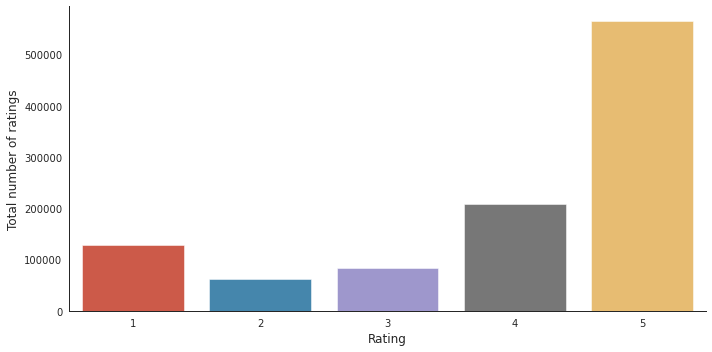

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=df_data_1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df_data_1.shape[0])
print("Total No of Users   :", len(np.unique(df_data_1.userId)))
print("Total No of products  :", len(np.unique(df_data_1.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048575
Total No of Users   : 786329
Total No of products  : 61893


In [ ]:
df_data_1.drop(['timestamp'], axis=1,inplace=True)


In [ ]:
no_of_rated_products_per_user = df_data_1.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [ ]:
no_of_rated_products_per_user.describe()


count    786329.000000
mean          1.333507
std           1.385613
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

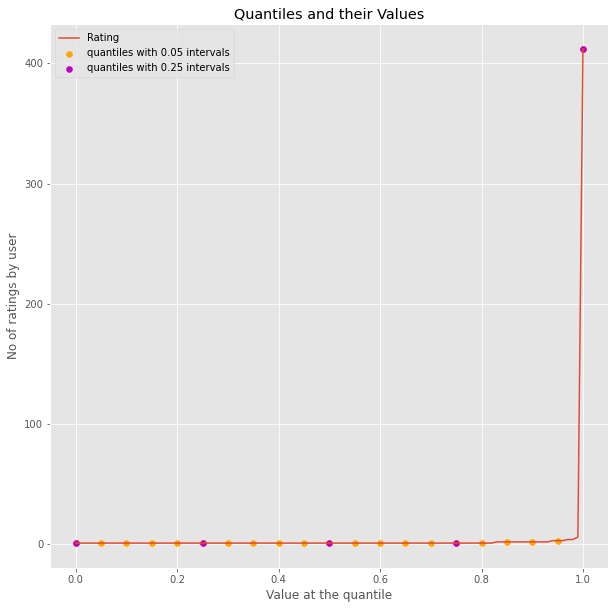

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [ ]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 38



In [ ]:

new_df=df_data_1.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

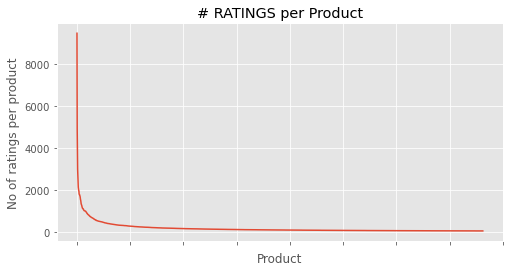

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [ ]:
new_df.groupby('productId')['Rating'].mean().head()

productId
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
1400532655    3.727273
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [ ]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()


productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [ ]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [ ]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [ ]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484


In [ ]:
ratings_mean_count['rating_counts'].max()


9487

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

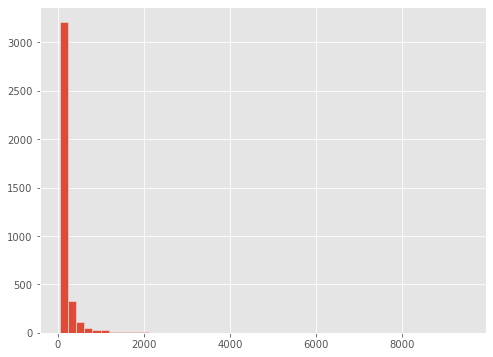

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

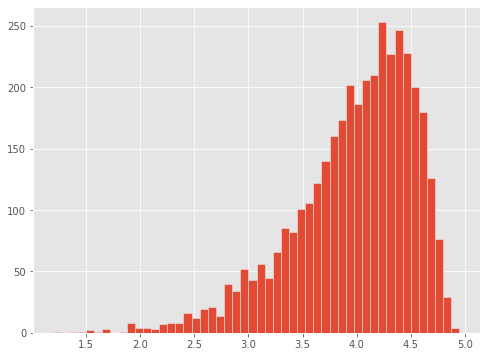

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

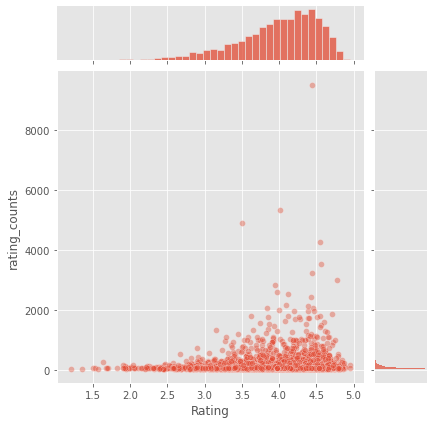

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

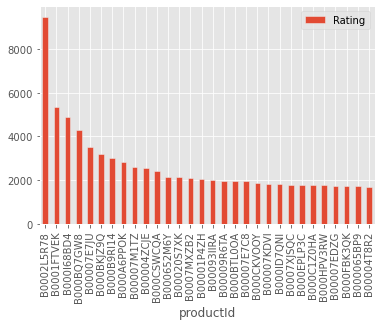

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

ModuleNotFoundError: ignored